# Group_25_Project

## Investigating the Relationship Between Volatile Acidity and Wine Quality 

The dataset used in this project contains information related to the Portuguese “Vinho Verde” red wine, inlcuding volatile acidity and quality rating, which we are interested in investigating. The wine is expert rated in a categorical variable from 1 (very bad) to 10 (very good) and contains no missing values. In this study, we will be focusing on the ratings of 5, 6 and 7.

Volatile acidity (g/dm³) is the measure of gaseous acids contained in wine. While naturally occuring as a product of wine fermentation, it can result in displeasant tastes and odors as an indication of spoilage and poor hygene practices when present in excess. According to the Code of Federal Regulations, the maxmimum amount of acceptable Volatile Acidity is 1.4 g/dm³. (Gardner, 2020). A statistical analysis by Jose, n.d. concludes a strong correlation and a decreasing trend between volatile acidity and quality. This begs the question: Is there a significant difference in volatile acidity across different quality ratings of wine?

We will conduct a multiple hypothesis test of ratings 5, 6, and 7 by calculating the mean and standard deviation of volatile acidity. As volatile acidity is a numeric variable, we can use mean as a point estimate because all the observations contribute equally. Since there are limited samples, we will use bootstraping to create resamples that will help estimate the sampling distribution. Moreover, standard deviation can help construct a confident interval, which approximates a possible range for the population parameter. We choose a standard 5% signficance level to account for the subjective nature of wine rating. Our null hypothesis is that there is no significant difference of volatile acidity, while the alternative hypothesis is that at least one out of the three ratings that significantly differs in level

In [1]:
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(broom)
library(digest)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Methods and Results
## ANOVA Test for three different wine rating groups
After careful analysis and discussion, we decided to apply ANOVA test first instead of multiple pair-wise tests in order to reduce the overlapping and error that is caused by multiple random selections. We will focus on the variance in and between each sample group (analysis of variance) to test if MST (the variation between treatments) can be fully explained by MSE (the random nature of the data or variance within each treatment). If we get a large F-value, that means MST is much larger than MSE and the null hypothesis is false. If we get an F-value which is approaching zero, that means MST can be fully explained by MSE and we will fail to reject the null hypothesis.
<br>
Our null hypothesis:
The volatile acidity level (g/dm^3) in 5-ratings group, 6-ratings group, and 7-ratings group is the same.
<br>
Our alternative hypothesis:
There is at least one group among the three groups whose volatile acidity level is different from others'.
<br>
We choose 0.05 as our significant(alpha) value.
<br>
Below is the code and the ANOVA table.

In [16]:
## filter and achieve the specific 3 rating groups data
wine_data_filtered <- read.csv("https://raw.githubusercontent.com/sonatuna/Group_25_Project/main/winequality-red.csv", sep = ";") |>
    mutate(quality = as.factor(quality)) |>
    filter(quality %in% c('5','6','7'))
## perform ANOVA test, volatile.acidity as the response variance and quality as the explanatory variable
anova_result <- aov(volatile.acidity ~ quality, data = wine_data_filtered)
## diplay the ANOVA table
summary(anova_result)

              Df Sum Sq Mean Sq F value Pr(>F)    
quality        2   5.22  2.6097     101 <2e-16 ***
Residuals   1515  39.15  0.0258                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Df (Degrees of Freedom) (first column):
    (first row) df1: This is 2 degrees of freedom. Since we only have 3 quality rating groups, the degrees of freedom is 3 (number of sample groups) -1 = 2.
    (second row) df2: This degrees of freedom is 1515, which is calculated as the total number of observations (1518) minus the number of groups (3).
## Sum Sq (Sum of Squares) (second column):
    (first row) (SSB Sum of Squares Between): The variance that can be explained by variation between the quality groups is 5.22.
    (second row) (SSE Sum of Squares of Error): The variance that cannot be explained by the quality groups and is due to individual variance, which is 39.15.
## Mean Sq (Mean Squares) (third column):
    (first row) (MST Mean Squares of Treatment): This is the explained variance (5.22) divided by its degrees of freedom (2), which equals to 2.6097.
    (second row) (MSE Mean Squares of Error): This is the unexplained variance (39.01) divided by its degrees of freedom (1515), which equals to 0.0258.
## F value (4th column):
    The computed F-value is 101. It is the ratio of explained variance to unexplained variance. A high F-value indicates that the group means are very likely to be not equal. Usually if the ratio is equal to one, it indicates that the variance can be fully explained by random selection error.
## Pr(>F) == P-value (5th column):
    This is the P-value that we need ultimately to compare with our significant level to decide whether or not to reject the null hypothesis. "<2e-16" means that our p-value here is aproximately equal to zero, indicating that it is very unlikely to ahcieve such sample groups assuming that our null hypothesis is true.
## Conclusion:
    The ANOVA test indicates a statistically significant difference in volatile acidity across the three different quality ratings of wine. Considering the extremely low p-value, we can reject the null hypothesis. We can conclude that there is at least one group among the three whose volatile acidity level is different from the others (the original alternative hypothesis). We need to make further tests to figure out which one or more rating groups' acidity level is different from the others.

## Multiple pairwise tests
Based on the conclusion from the ANOVA test, our next step is to perform multiple pair-wise tests to determine which group's acidity level is different from the others. In total, we are going to perform pairwise tests three times: 5-rating group VS 6-rating group; 6-rating group VS 7-rating group; 5-rating group VS 7-rating group.
<br>
We will explain the first test in detail, then briefly summarize the rest two since the process is highly repetitive.

### 5-rating group VS 6-rating group
We want to compare 5-rating group with 6-rating group to see if there is a statistically significant difference between these two groups in the level of volatile acidity.
<br>
Null hypothesis: The level of volatile acidity between these two groups are the same.
<br>
Alternative hypothesis: The level of volatile acidity between these two groups differ.
<br>
Siginificance level: 0.05
<br>
First, we calculate the observed difference in means.

In [20]:
obs_diff_in_means <- wine_data_filtered |>
    filter(quality %in% c('5', '6')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("5", "6"))
obs_diff_in_means
print("Table 2: Observed Difference in Means between Group 5 and 6")

Dropping unused factor levels c("3", "4", "7", "8") from the supplied explanatory variable 'quality'.



stat      
1 0.07955679

[1] "Table 2: Observed Difference in Means between Group 5 and 6"


Then, using permutation, we generate a null model(distribution) assuming our null hypothesis is true. To make our analysis reproducible, we set a seed here (also for the rest two tests).

In [21]:
set.seed(2023)
null_model_acidity <- 
    wine_data_filtered|>
    filter(quality %in% c('5', '6')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("5", "6"))
head(null_model_acidity)
print("Table 3: Difference in Means between Groups 5 and 6")

Dropping unused factor levels c("3", "4", "7", "8") from the supplied explanatory variable 'quality'.



replicate stat        
1 1         -0.006007991
2 2          0.004131671
3 3         -0.009757237
4 4          0.001945875
5 5         -0.007222322
6 6         -0.001120310

[1] "Table 3: Difference in Means between Groups 5 and 6"


## Visulization of null model, observed difference in means, and confidence interval
We visualized the null distribution and the observed difference in means. We have also created a visualize of the 95% confidence interval to help our audience to form a good understanding the relation between the null distribution and the observed difference.

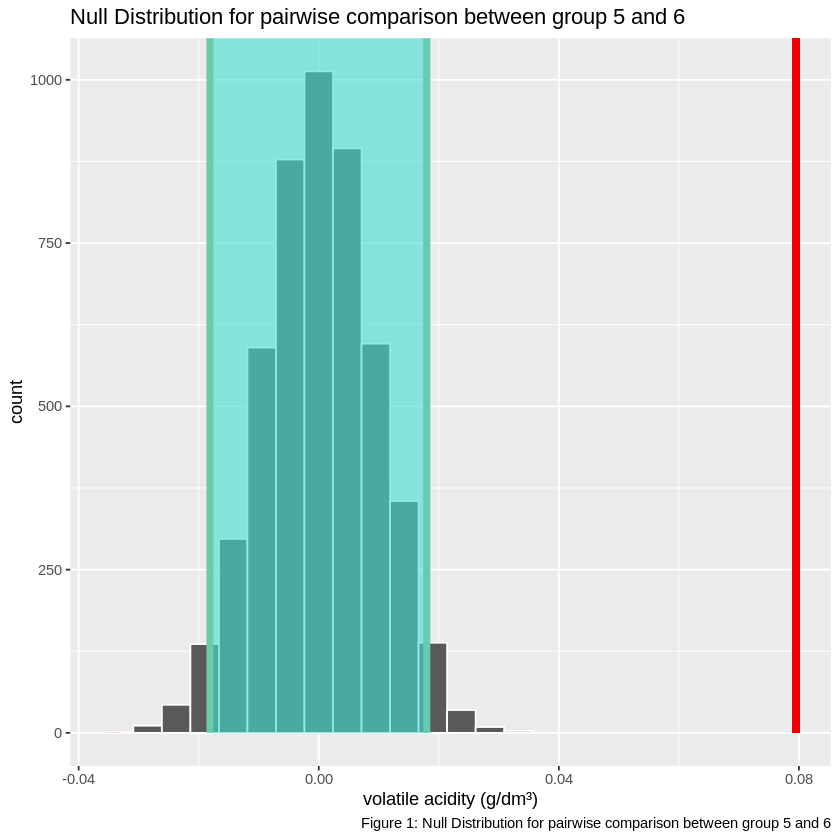

In [22]:
first_null_ci <- 
    null_model_acidity %>% 
    summarise(lower_ci = quantile(stat, 0.025), upper_ci = quantile(stat, 0.975))
acidity_result_plot <- 
   null_model_acidity %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means, direction = "both") +
   labs(x = 'volatile acidity (g/dm³)', caption = "Figure 1: Null Distribution for pairwise comparison between group 5 and 6") +
    ggtitle("Null Distribution for pairwise comparison between group 5 and 6") +
    shade_confidence_interval(endpoints = first_null_ci)

acidity_result_plot

The histogram is the null distribution generated by permutation and the red line indicates the observed difference in means(of the rating groups). Therefore, we suspect that it is very unlikely to get the observed difference in means assuming that the null hypothesis is true. To prove our suspection, we need to calculate the p-value and compare it with our significance level.

In [23]:
p_value <- null_model_acidity |>
   get_p_value(obs_stat = obs_diff_in_means, direction = "both")
p_value
print("Table 4: P Value of Group 5 and 6 Comparison")

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
1 0

[1] "Table 4: P Value of Group 5 and 6 Comparison"


## P-Correction
Since we are more likely to commit a Type I error as we will test three hypotheses in total. We want to use the Bonferroni adjustment to reduce the likelihood of committing a Type I error.

In [7]:
p_value_adjusted <- p.adjust(p_value, method = "bonferroni")
p_value_adjusted

p_value 
      0

It is obvious that the p-value is sigificantly smaller than our siginicance level (0.05). Hence, we have evidence to reject the null hypothesis and conclude that there is a statiscally siginificant difference between the means of 5-rating group and 6-rating group.
## Two Sample t-test

We also performed a two sample t-test to make sure that our conclusion is robust and accurate since the p-value we got previously is extremely small. 

In [24]:
first_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "5") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "6") |> pull(volatile.acidity)))
first_t_test
print("Table 5: Two Sample Test between Groups 5 and 6")

estimate   estimate1 estimate2 statistic p.value      parameter conf.low 
1 0.07955679 0.5770411 0.4974843 8.867539  2.384872e-18 1314.712  0.0619564
  conf.high  method                  alternative
1 0.09715718 Welch Two Sample t-test two.sided

[1] "Table 5: Two Sample Test between Groups 5 and 6"


## The rest two Pairwise tests: 6-rating group vs 7-rating group; 5-rating group vs 7-rating group
We follow the same procedure fot these two tests.
<br>
<br>
Our null hypothesis: The level of volatile acidity between 6-rating group and 7-rating group are the same;
<br>
The level of volatile acidity between 5-rating group and 7-rating group are the same.
<br>
<br>
Our alternative hypothesis: The level of volatile acidity between 6-rating group and 7-rating group are different;
<br>
The level of volatile acidity between 5-rating group and 7-rating group are different.
<br>
<br>
Siginificance level: 0.05


Dropping unused factor levels c("3", "4", "5", "8") from the supplied explanatory variable 'quality'.



stat      
1 0.09356473

[1] "Table 6: Observed Difference in Means between Groups 6 and 7"


Dropping unused factor levels c("3", "4", "5", "8") from the supplied explanatory variable 'quality'.



replicate stat        
1 1         -0.014288960
2 2          0.006081938
3 3          0.012147060
4 4          0.012081135
5 5          0.018508845
6 6          0.009015611

[1] "Table 6: Null Model of Comparison between Groups 6 and 7"


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
1 0

[1] "Table 7: P Value of Comparing Groups 6 and 7"


p_value
1 0

[1] "Table 8: Adjusted P Value of Comparison between Groups 6 and 7"


estimate   estimate1 estimate2 statistic p.value     parameter conf.low  
1 0.09356473 0.4974843 0.4039196 7.727874  1.08632e-13 362.2767  0.06975505
  conf.high method                  alternative
1 0.1173744 Welch Two Sample t-test two.sided

[1] "Table 9: T-Test of Comparison between Groups 6 and 7"


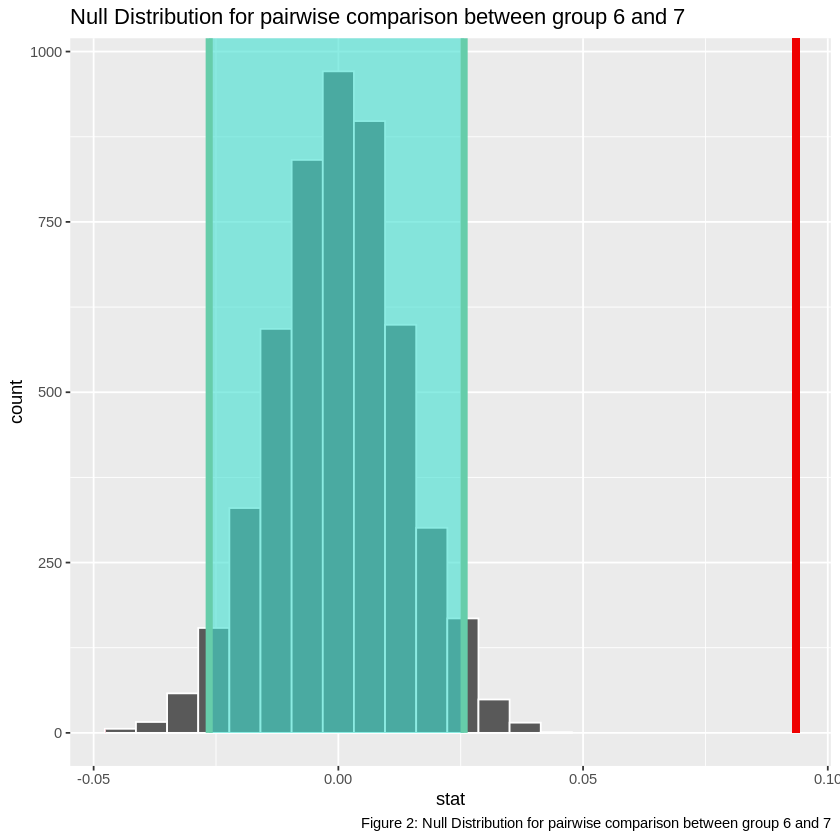

In [26]:
## 6-rating group vs 7-rating group
set.seed(2023)
obs_diff_in_means_2 <- wine_data_filtered |>
    filter(quality %in% c('6', '7')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("6", "7"))
obs_diff_in_means_2
print("Table 6: Observed Difference in Means between Groups 6 and 7")

null_model_acidity_2 <- 
    wine_data_filtered|>
    filter(quality %in% c('6', '7')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("6", "7"))
head(null_model_acidity_2)
print("Table 6: Null Model of Comparison between Groups 6 and 7")

second_null_ci <- 
    null_model_acidity_2 %>% 
    summarise(lower_ci = quantile(stat, 0.025), upper_ci = quantile(stat, 0.975))
acidity_result_plot_2 <- 
   null_model_acidity_2 %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means_2, direction = "both") +
   labs('volatile acidity (g/dm³)', caption = "Figure 2: Null Distribution for pairwise comparison between group 6 and 7") +
    ggtitle("Null Distribution for pairwise comparison between group 6 and 7") +
    shade_confidence_interval(endpoints = second_null_ci)
acidity_result_plot_2

p_value_2 <- null_model_acidity_2 |>
   get_p_value(obs_stat = obs_diff_in_means_2, direction = "both")
p_value_2
print("Table 7: P Value of Comparing Groups 6 and 7")

p_value_adjusted_2 <- p_value_2 * 3
p_value_adjusted_2
print("Table 8: Adjusted P Value of Comparison between Groups 6 and 7")

second_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "6") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "7") |> pull(volatile.acidity)))
second_t_test
print("Table 9: T-Test of Comparison between Groups 6 and 7")


Dropping unused factor levels c("3", "4", "6", "8") from the supplied explanatory variable 'quality'.



stat     
1 0.1731215

Dropping unused factor levels c("3", "4", "6", "8") from the supplied explanatory variable 'quality'.



replicate stat         
1 1          0.0242892510
2 2          0.0007501162
3 3          0.0187697297
4 4          0.0165294534
5 5          0.0205879249
6 6         -0.0009706757

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
1 0

p_value
1 0

estimate  estimate1 estimate2 statistic p.value      parameter conf.low 
1 0.1731215 0.5770411 0.4039196 14.33441  3.445569e-37 360.2057  0.1493706
  conf.high method                  alternative
1 0.1968725 Welch Two Sample t-test two.sided

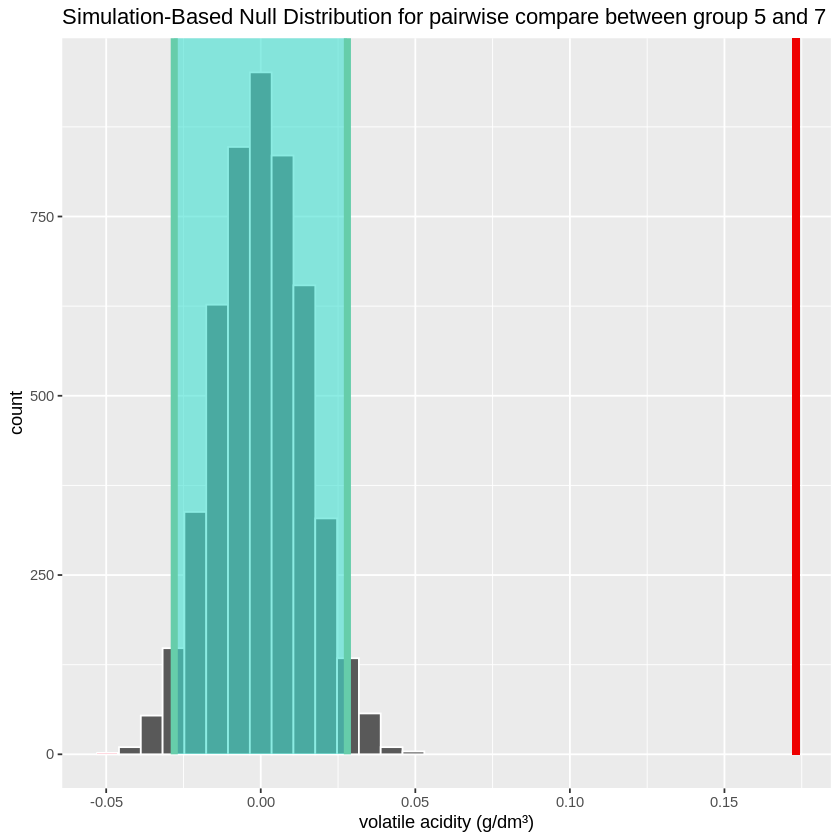

In [13]:
set.seed(2023)
obs_diff_in_means_3 <- wine_data_filtered |>
    filter(quality %in% c('5', '7')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("5", "7"))
obs_diff_in_means_3
print("Table 10: Observed Difference in Means between Groups 5 and 7")
null_model_acidity_3 <- 
    wine_data_filtered|>
    filter(quality %in% c('5', '7')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("5", "7"))
head(null_model_acidity_3)
print("Table 6: Null Model of Comparison between Groups 5 and 7")

third_null_ci <- 
    null_model_acidity_3 %>% 
    summarise(lower_ci = quantile(stat, 0.025), upper_ci = quantile(stat, 0.975))
acidity_result_plot_3 <- 
   null_model_acidity_3 %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means_3, direction = "both") +
   labs('volatile acidity (g/dm³)', caption = "Figure 3: Simulation-Based Null Distribution for pairwise compare between group 5 and 7") +
    ggtitle("Simulation-Based Null Distribution for pairwise compare between group 5 and 7") +
    shade_confidence_interval(endpoints = third_null_ci)

acidity_result_plot_3
p_value_3 <- null_model_acidity_3 |>
   get_p_value(obs_stat = obs_diff_in_means_3, direction = "both")
p_value_3
print("Table 7: P Value of Comparing Groups 5 and 7")

p_value_adjusted_3 <- p_value_3 * 3
p_value_adjusted_3
print("Table 7: Adjusted P Value of Comparing Groups 5 and 7")

third_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "5") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "7") |> pull(volatile.acidity)))
third_t_test
print("Table 7: T-test of Comparing Groups 5 and 7")

Both tests' plots indicate that observed difference in means is very unlikely to obtain and the p-values that we get from bootstrap and two sample t-test are all approaching zero. We can conclude that 6-rating group's acidity level is different from 7-rating group's acidity level, and 5-rating group's acidity level is different from 7-rating group's acidity level too.

## conclusion of results
We have strong evidences indicating that all of the three groups' acidity level is statiscally and significantly different from each other. As we take a further look at the three plots and test results provided by the t-tests above, we suspect that among the three different rating groups, the 5-rating group have the highest volatile acidity level while the 6-rating group have the smallest volatile acidity level. That being said, this is only an educated assumption. We used both bootstrap and asymptotic approaches in our methods, and produced a similar conclusion in each. However, we believe that the bootstrap approach is a better fit in our case as our sample size for different rating groups varies a lot, and bootstrap may perform better for small sample sizes and non-standard dsitributions since it does not rely on strong assumptions about the data (such as assuming the data follows a t-distribution).

# Discussion

In this study, we first conducted an ANOVA test, which then conducting the pair-wise t-tests for the rating groups 5, 6, and 7, we obtained a p value of 0 for each of the groups and evidently rejected the null hypothesis, "there is no difference in volatile acidity levels between the quality ratings 5, 6, and 7". Some assumptions were made about the methods and results, specifically that the distribution was assumed to be normal and that the groups must have similar variance in order to apply the t test. Similarly, the ANOVA test assumes a normal distribution and equal variance, as well as requires the data to have random, independent sampling. However, bootstrapping and permuatation helps reduce assumptions made on the data. 

While not explicitly concluded this study, the differing VA levels in our findings helps support the theory that higher wine quality contains lower VA. These results may validate the higher price of expensive wines due to higher quality, and provide insight for consumer choices. The fact that VA levels differ for quality align with research, so it is what we expected to find. In fact, we obtained near zero p-values, which was very ideal and exceeded our expectations. One extension to this study is to build a predictive model to predict quality rating and utilize our findings in this study to decide if volatile acidity is a significant predictor or not.